In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np


In [81]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
bitcoin_market_info.columns = bitcoin_market_info.columns.str.replace("*", "")
# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-09-19,6371.85,6448.46,6208.34,6398.54,4431340000,110074137715
1,2018-09-18,6280.91,6384.18,6265.71,6371.30,4180090000,108492112339
2,2018-09-17,6514.06,6540.21,6257.52,6281.20,3910780000,112508446995
3,2018-09-16,6536.68,6544.33,6460.10,6517.18,3273730000,112887643665
4,2018-09-15,6509.40,6561.72,6493.55,6543.20,3216300000,112405369809


In [82]:
# getting the Bitcoin and Eth logos
import sys
from PIL import Image
import io

if sys.version_info[0] < 3:
    import urllib2 as urllib
    bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
else:
    import urllib
    bt_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

### Rename columns

In [83]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]

### Merge Ethereum with Bitcoin 

In [86]:
market_info = bitcoin_market_info
market_info = market_info[market_info['Date']>='2016-01-01']
for coins in ['bt_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)

print(market_info)

          Date  bt_Open  bt_High   bt_Low  bt_Close   bt_Volume  \
0   2018-09-19  6371.85  6448.46  6208.34   6398.54  4431340000   
1   2018-09-18  6280.91  6384.18  6265.71   6371.30  4180090000   
2   2018-09-17  6514.06  6540.21  6257.52   6281.20  3910780000   
3   2018-09-16  6536.68  6544.33  6460.10   6517.18  3273730000   
4   2018-09-15  6509.40  6561.72  6493.55   6543.20  3216300000   
5   2018-09-14  6515.41  6596.10  6456.17   6512.71  4076220000   
6   2018-09-13  6354.24  6535.41  6354.24   6517.31  4210910000   
7   2018-09-12  6317.01  6363.87  6265.09   6351.80  4064230000   
8   2018-09-11  6331.88  6398.92  6260.21   6321.20  3849910000   
9   2018-09-10  6301.57  6374.98  6292.76   6329.70  3714100000   
10  2018-09-09  6223.38  6446.26  6201.22   6300.86  3671890000   
11  2018-09-08  6460.17  6534.25  6197.52   6225.98  3835060000   
12  2018-09-07  6528.92  6555.29  6396.87   6467.07  4264680000   
13  2018-09-06  6755.14  6755.14  6404.72   6529.17  552347000

In [87]:
%matplotlib inline

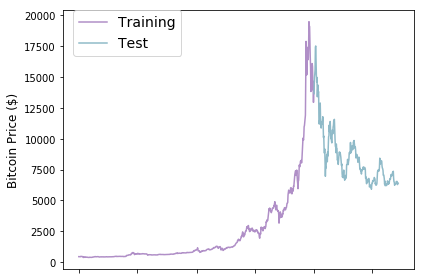

In [88]:
split_date = '2018-01-01'
fig, (ax1) = plt.subplots()
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#8FBAC8', label='Test')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
             200, 260, zorder=3,alpha=.5)
plt.show()

## LSTM 

In [91]:
for coins in ['bt_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [92]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility
992,2016-01-01,434.33,36278900,-0.560137,0.020268
991,2016-01-02,433.44,30096600,0.250597,0.009641
990,2016-01-03,430.01,39633800,-0.173865,0.020827
989,2016-01-04,433.09,38477500,-0.474265,0.012649
988,2016-01-05,431.96,34522600,-0.013333,0.010391


In [93]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [94]:
window_len = 10
norm_cols = [coin+metric for coin in ['bt_'] for metric in ['Close','Volume']]

In [95]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1

In [96]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['bt_Close'][window_len:].values/test_set['bt_Close'][:-window_len].values)-1

In [97]:
LSTM_training_inputs[0]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility
992,0.000000,0.000000,-0.560137,0.020268
991,-0.002049,-0.170410,0.250597,0.009641
990,-0.009946,0.092475,-0.173865,0.020827
989,-0.002855,0.060603,-0.474265,0.012649
988,-0.005457,-0.048411,-0.013333,0.010391
987,-0.012019,-0.061645,-0.003623,0.012782
986,0.054613,1.413585,-0.951499,0.069045
985,0.043515,0.570968,0.294196,0.032762
984,0.030576,-0.110282,0.814194,0.017094
983,0.031451,-0.007801,-0.919598,0.017758


In [98]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [99]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [110]:
# random seed for reproducibility
np.random.seed(202)

pred_range = 10


# =============================================================================================
# # # random seed for reproducibility
# np.random.seed(202)
# # we'll try to predict the closing price for the next 5 days 
# # change this value if you want to make longer/shorter prediction
# pred_range = 10
# # initialise model architecture
# bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# # model output is next 5 prices normalised to 10th previous closing price
# LSTM_training_outputs = []
# for i in range(window_len, len(training_set['bt_Close'])-pred_range):
#     LSTM_training_outputs.append((training_set['bt_Close'][i:i+pred_range].values/
#                                   training_set['bt_Close'].values[i-window_len])-1)
# LSTM_training_outputs = np.array(LSTM_training_outputs)
# # train model on data
# # note: eth_history contains information on the training error per epoch
# bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
#                             epochs=50, batch_size=20, verbose=2, shuffle=False)
# =============================================================================================


# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next price normalised to 10th previous closing price
"""
We don't use this approach when we try predicting +1 points in the future!
"""
# LSTM_training_outputs = (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1
"""
Instead, we set the training_outputs as follows:
"""
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_Close'][i:i+pred_range].values/
                                  training_set['bt_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)

# train model on data
# batch_size=1 !! NOO ! IT SHOULD BE len(data)-window
# note: eth_history contains information on the training error per epoch
"""
Same can be argued for the following line; we have to have 
same number of inputs as outputs, since its a sueprvised ml network
=> modify it 
"""
# bt_history = bt_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
#                             epochs=50, batch_size=50, verbose=2, shuffle=False)
"""
And here is how it looks ^^ 
"""
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=20, verbose=2, shuffle=False)

Epoch 1/50
 - 1s - loss: 0.1433
Epoch 2/50
 - 0s - loss: 0.1223
Epoch 3/50
 - 0s - loss: 0.1160
Epoch 4/50
 - 0s - loss: 0.1104
Epoch 5/50
 - 0s - loss: 0.1049
Epoch 6/50
 - 0s - loss: 0.1003
Epoch 7/50
 - 0s - loss: 0.0968
Epoch 8/50
 - 0s - loss: 0.0921
Epoch 9/50
 - 0s - loss: 0.0896
Epoch 10/50
 - 0s - loss: 0.0890
Epoch 11/50
 - 0s - loss: 0.0861
Epoch 12/50
 - 1s - loss: 0.0854
Epoch 13/50
 - 0s - loss: 0.0837
Epoch 14/50
 - 0s - loss: 0.0824
Epoch 15/50
 - 0s - loss: 0.0828
Epoch 16/50
 - 0s - loss: 0.0811
Epoch 17/50
 - 0s - loss: 0.0808
Epoch 18/50
 - 0s - loss: 0.0813
Epoch 19/50
 - 0s - loss: 0.0791
Epoch 20/50
 - 0s - loss: 0.0798
Epoch 21/50
 - 0s - loss: 0.0787
Epoch 22/50
 - 0s - loss: 0.0788
Epoch 23/50
 - 0s - loss: 0.0779
Epoch 24/50
 - 0s - loss: 0.0775
Epoch 25/50
 - 0s - loss: 0.0779
Epoch 26/50
 - 0s - loss: 0.0776
Epoch 27/50
 - 0s - loss: 0.0770
Epoch 28/50
 - 0s - loss: 0.0769
Epoch 29/50
 - 0s - loss: 0.0762
Epoch 30/50
 - 0s - loss: 0.0758
Epoch 31/50
 - 0s -

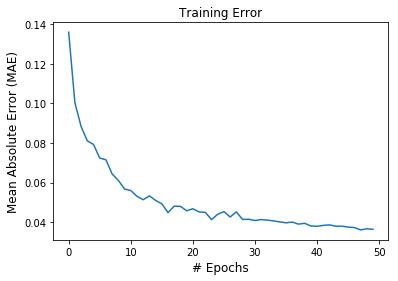

In [104]:

fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

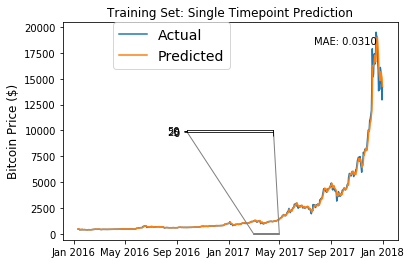

In [105]:

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_Close'].values[window_len:])/(training_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 3.35, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
axins.set_ylim([10,60])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

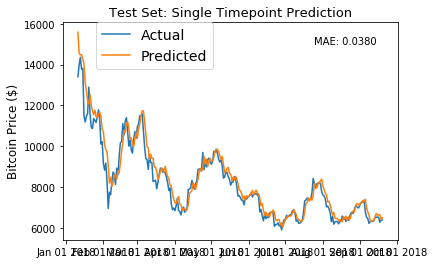

In [107]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close'].values[window_len:])/(test_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

### Now for Bitcoin 

In [37]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs, 
                            (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)
# #eth_model.save('eth_model%d.h5'%j)

Epoch 1/50
 - 4s - loss: 0.0980
Epoch 2/50
 - 3s - loss: 0.0629
Epoch 3/50
 - 6s - loss: 0.0501
Epoch 4/50
 - 3s - loss: 0.0457
Epoch 5/50
 - 10s - loss: 0.0408
Epoch 6/50
 - 7s - loss: 0.0407
Epoch 7/50
 - 7s - loss: 0.0374
Epoch 8/50
 - 4s - loss: 0.0372
Epoch 9/50
 - 7s - loss: 0.0365
Epoch 10/50
 - 6s - loss: 0.0343
Epoch 11/50
 - 5s - loss: 0.0357
Epoch 12/50
 - 3s - loss: 0.0354
Epoch 13/50
 - 4s - loss: 0.0351
Epoch 14/50
 - 7s - loss: 0.0339
Epoch 15/50
 - 6s - loss: 0.0328
Epoch 16/50
 - 6s - loss: 0.0330
Epoch 17/50
 - 8s - loss: 0.0334
Epoch 18/50
 - 5s - loss: 0.0327
Epoch 19/50
 - 4s - loss: 0.0340
Epoch 20/50
 - 4s - loss: 0.0313
Epoch 21/50
 - 4s - loss: 0.0322
Epoch 22/50
 - 4s - loss: 0.0331
Epoch 23/50
 - 4s - loss: 0.0323
Epoch 24/50
 - 4s - loss: 0.0322
Epoch 25/50
 - 4s - loss: 0.0324
Epoch 26/50
 - 4s - loss: 0.0315
Epoch 27/50
 - 4s - loss: 0.0326
Epoch 28/50
 - 4s - loss: 0.0322
Epoch 29/50
 - 4s - loss: 0.0317
Epoch 30/50
 - 4s - loss: 0.0315
Epoch 31/50
 - 3s 

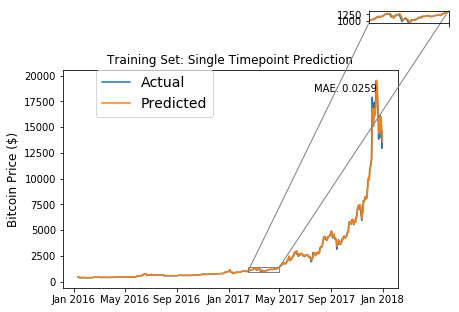

In [38]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_Close'].values[window_len:])/(training_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 2, 15), datetime.date(2017, 5, 1)])
axins.set_ylim([920, 1400])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

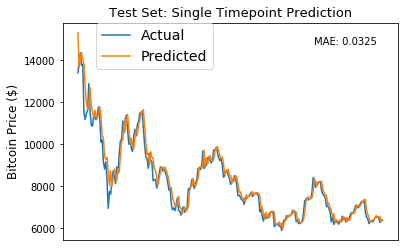

In [39]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close'].values[window_len:])/(test_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [118]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 50
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_Close'][i:i+pred_range].values/
                                  training_set['bt_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=20, verbose=2, shuffle=False)

Epoch 1/50
 - 1s - loss: 0.2347
Epoch 2/50
 - 0s - loss: 0.2136
Epoch 3/50
 - 0s - loss: 0.2032
Epoch 4/50
 - 0s - loss: 0.1989
Epoch 5/50
 - 0s - loss: 0.1965
Epoch 6/50
 - 0s - loss: 0.1953
Epoch 7/50
 - 0s - loss: 0.1923
Epoch 8/50
 - 0s - loss: 0.1900
Epoch 9/50
 - 0s - loss: 0.1897
Epoch 10/50
 - 0s - loss: 0.1883
Epoch 11/50
 - 1s - loss: 0.1863
Epoch 12/50
 - 1s - loss: 0.1854
Epoch 13/50
 - 0s - loss: 0.1838
Epoch 14/50
 - 0s - loss: 0.1829
Epoch 15/50
 - 0s - loss: 0.1810
Epoch 16/50
 - 0s - loss: 0.1810
Epoch 17/50
 - 0s - loss: 0.1810
Epoch 18/50
 - 0s - loss: 0.1800
Epoch 19/50
 - 0s - loss: 0.1789
Epoch 20/50
 - 0s - loss: 0.1789
Epoch 21/50
 - 0s - loss: 0.1770
Epoch 22/50
 - 0s - loss: 0.1768
Epoch 23/50
 - 0s - loss: 0.1774
Epoch 24/50
 - 0s - loss: 0.1756
Epoch 25/50
 - 0s - loss: 0.1777
Epoch 26/50
 - 0s - loss: 0.1755
Epoch 27/50
 - 0s - loss: 0.1751
Epoch 28/50
 - 0s - loss: 0.1758
Epoch 29/50
 - 0s - loss: 0.1764
Epoch 30/50
 - 0s - loss: 0.1744
Epoch 31/50
 - 0s -

In [116]:
np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-(training_set['bt_Close'].values[window_len:])/(training_set['bt_Close'].values[:-window_len])))

0.10955379754488455

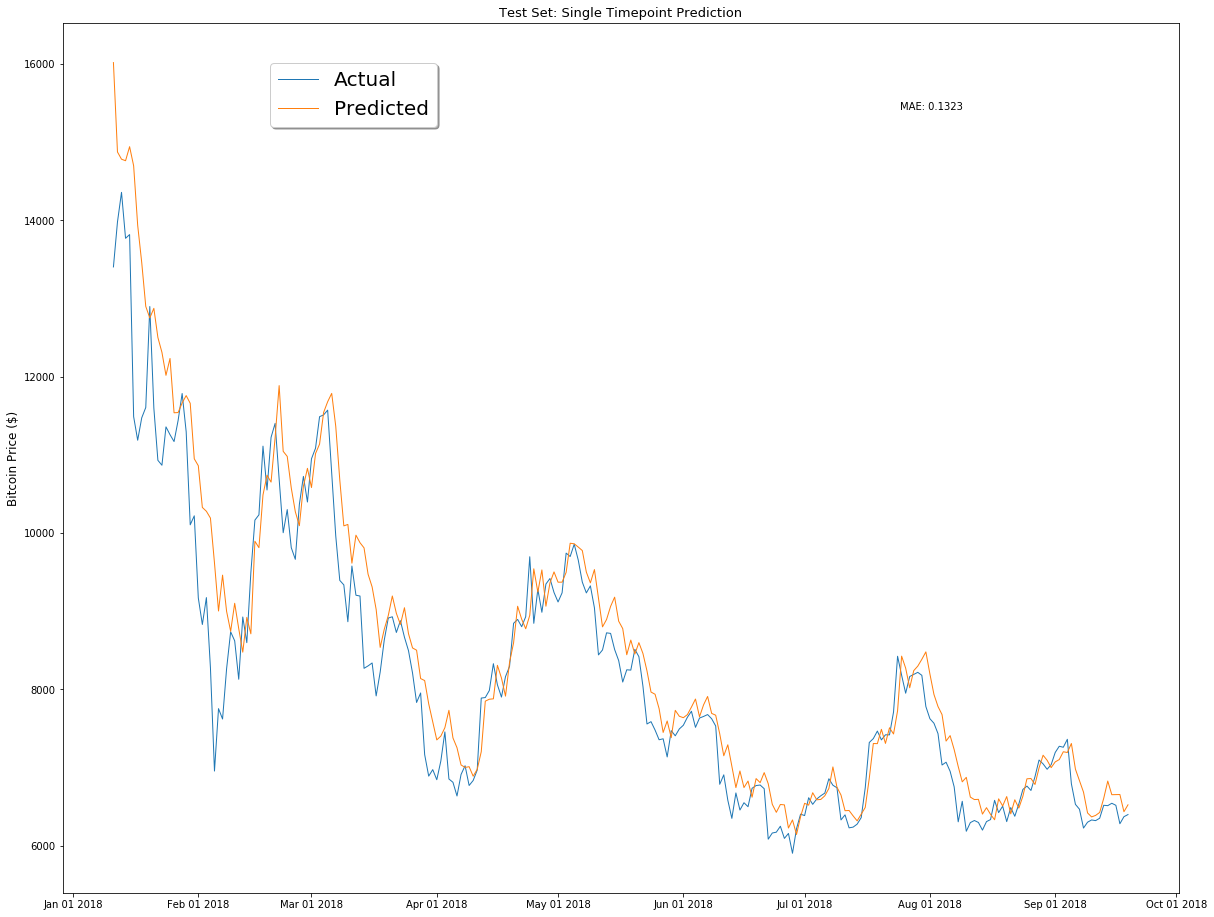

In [119]:
# %matplotlib inline
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 1
rcParams['figure.figsize'] = (20, 16)

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')

ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')

ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close'].values[window_len:])/(test_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
plt.show()